In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Carga de dataset en dataframe
df = pd.read_csv('BankChurners.csv', sep=',')
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


## Análisis Exploratorio de Datos (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [4]:
# Descripción de campos no numéricos
df.describe(exclude=[np.number])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


Nota: de los 10,127 registros, 8500 son Existing Customer , por lo que 1627 son Attrited Customer, es decir solo el 16.06% del total de los registros, por lo que es un dataset con desbalanceo de clases. 

In [5]:
# Descripción de campos numéricos 
df. describe(exclude=[object])

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


In [6]:
# Revisión de valores nulos
df.isna().sum().sort_values(ascending=False)

CLIENTNUM                                                                                                                             0
Contacts_Count_12_mon                                                                                                                 0
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1    0
Avg_Utilization_Ratio                                                                                                                 0
Total_Ct_Chng_Q4_Q1                                                                                                                   0
Total_Trans_Ct                                                                                                                        0
Total_Trans_Amt                                                                                                                       0
Total_Amt_Chng_Q4_Q1                            

In [7]:
# Eliminación de columnas sin datos relevantes para el modelo
df = df.iloc[:,1:-2]
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Outliers

Dado que existen alrededor de 10,000 registros, en lugar de eliminar outliers, reemplazaré sus datos con los valores máximos dentro de los límites. 

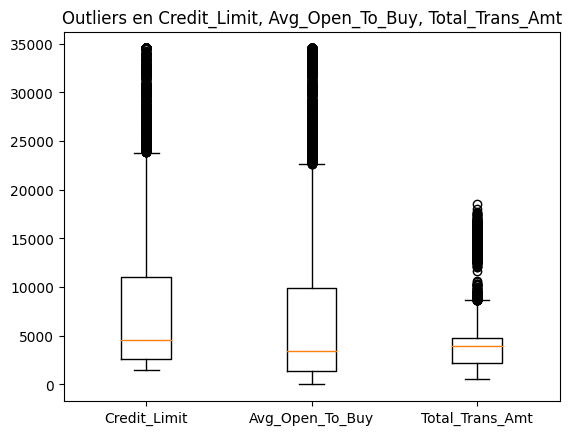

In [8]:
plt.boxplot(df[['Credit_Limit', 'Avg_Open_To_Buy','Total_Trans_Amt']],labels=['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt'])
plt.title('Outliers en Credit_Limit, Avg_Open_To_Buy, Total_Trans_Amt')
plt.show()

In [9]:
# Función para reemplazar valores de outliers
def outliers(n):
    if (n>=upper_limit):
        return upper_limit
    else:
        return n

In [10]:
# Imputación de valores en outliers a través de bucle "for"
cols = ['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt']

for i in cols:
    perc_25 = df[i].quantile(.25)
    perc_75 = df[i].quantile(.75)
    
    iqr = perc_75 - perc_25

    upper_limit = perc_75 + 1.5 * iqr
    df[i]=df[i].apply(outliers)

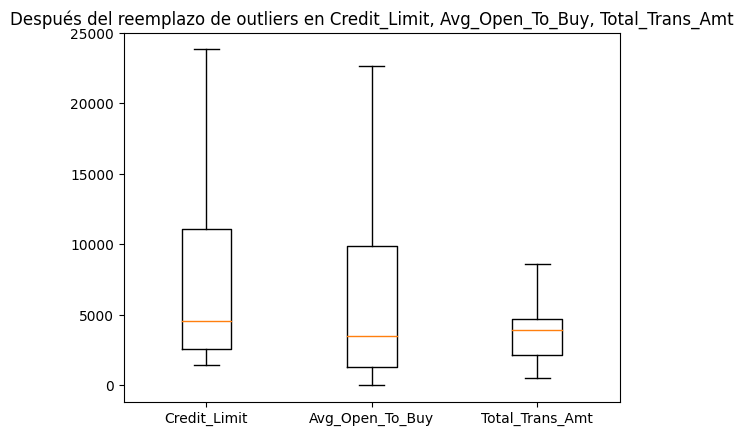

In [11]:
# Reviso el reemplazo correcto de outliers por los límites superiores
plt.boxplot(df[['Credit_Limit','Avg_Open_To_Buy', 'Total_Trans_Amt']],labels=['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt'])
plt.title('Después del reemplazo de outliers en Credit_Limit, Avg_Open_To_Buy, Total_Trans_Amt')
plt.show()

In [12]:
# Revisión de estadísticos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,7882.309381,7217.091225,1438.3,2555.000,4549.000,11067.500,23836.250
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,6720.676247,7223.542192,3.0,1324.500,3474.000,9859.000,22660.750
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [13]:
# Revisión de balanceo de dataset
df['Attrition_Flag'].value_counts(normalize=True)*100

Existing Customer    83.934038
Attrited Customer    16.065962
Name: Attrition_Flag, dtype: float64

In [14]:
# Mapeo de columna target a valores binarios (0 y 1)
df['Attrition_Flag']=df['Attrition_Flag'].map({'Existing Customer':0, 'Attrited Customer':1})

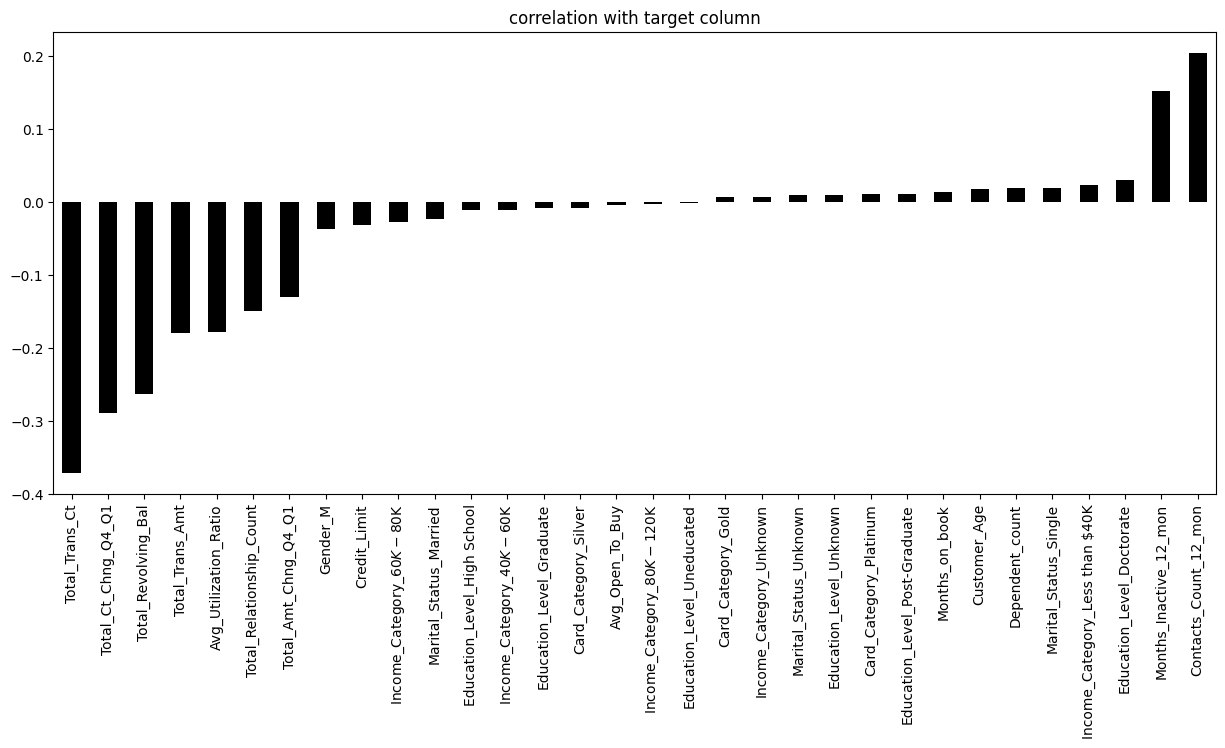

In [15]:
# Asociación de atributos con la variable objetivo
plt.figure(figsize=(15,6),dpi=100)
pd.get_dummies(df,drop_first=True).corr()['Attrition_Flag'].sort_values()[:-1].plot(kind='bar',color = 'black')
plt.title('correlation with target column')
plt.show()


### Feature Engineering

In [17]:
# Conversikón de variables categóricas a variables dummies
df= pd.get_dummies(df, drop_first=True)
df.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,0,1,0,0,0,0,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,1,0,0,0,0,1,0,0,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,0,1,0,0,0,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,1,0,0,0,1,0,0,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,0,1,0,0,0,0,0,0


### Train-test split, creación de (X,y) y Reescalamiento de datos

In [21]:
# Creación de variables explicativas y variable objetivo (X,y)
X = df.drop('Attrition_Flag',axis=1)
y = df['Attrition_Flag']

In [23]:
# Creación de subconjuntos de entrenamiento y testeo, subconjunto de entrenamiento 70% y testeo 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# Instancío la clase StandardScaler de Scikit-Learn
scale = StandardScaler()

In [25]:
# Reescalo los datos con StandardScaler
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

### Elección y entrenamiento de Modelo

In [26]:
# Instancío modelo de elección XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic')

In [27]:
# Ajuste de hiperparámetros para  búsqueda en cuadrícula con validación cruzada (Grid Search CV) 
parametros = {'n_estimators':[90,110,120],'max_depth':[4,6,9,11],'learning_rate':[.3,.6,.8],'min_child_weight':[3,5,8],'subsample':[.75]}

In [28]:
# Selección de métricas de evaluación 
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [29]:
# Instancío 'Grid Search CV' y ajusto refit a recall_
grid_model_xgb = GridSearchCV(xgb_model, param_grid=parametros, cv=5, scoring=scoring, refit='recall')


In [30]:
# Entrenamiento del modelo con medición del tiempo de ejecución
%%time
grid_model_xgb.fit(X_train_scaled, y_train)

CPU times: user 11min 21s, sys: 3.62 s, total: 11min 25s
Wall time: 11min 43s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.3, 0.6, 0.8],
                         'max_depth': [4, 6, 9, 11],
                         'min_child_weight': [3, 5, 8],
                         'n_estimators': [90, 110, 120], 'subsample': [0.75]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
# Mejor score
grid_model_xgb.best_score_

0.8923665169232878

In [33]:
# Mejores hiperparámetros
grid_model_xgb.best_params_

{'learning_rate': 0.3,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 90,
 'subsample': 0.75}

In [38]:
# Instancío modelo final con el ajuste de mejores hiperparámetros
xgb_model_final = XGBClassifier(objective='binary:logistic', learning_rate = 0.3, max_depth = 4, min_child_weight = 3, n_estimators = 90, subsample = 0.75)

In [42]:
# Entreno modelo final
xgb_model_final.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
y_pred =xgb_model_final.predict(X_test_scaled)

### Evaluación del modelo

In [44]:
# Matríz de confusión
confusion_matrix(y_test,y_pred)

array([[2079,   34],
       [  49,  370]])

34 Falsos positivos y 49 Falsos negativos

In [45]:
# AUC Score
roc_auc_score(y_test, y_pred)

0.9334820132671144

In [46]:
scores = {'Accuracy':accuracy_score(y_test,y_pred),'F1_score':f1_score(y_test,y_pred),'Recall':recall_score(y_test,y_pred),'Precision':precision_score(y_test,y_pred)}
scores

{'Accuracy': 0.967219589257504,
 'F1_score': 0.8991494532199271,
 'Recall': 0.883054892601432,
 'Precision': 0.9158415841584159}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3f629bea-7665-4c8b-b6fe-13c2a452a309' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>